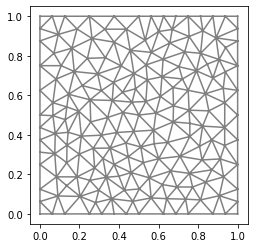

In [91]:
from dolfin import *
from mshr import *
import numpy as np

square = Rectangle(Point(0, 0), Point(1., 1.))
domain = square 
mesh = generate_mesh(domain, 10)
plot(mesh)

In [92]:
class Top(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 1., 1e-8) and on_boundary
def symmetry_x(x, on_boundary):
        return near(x[0], 0., 1e-8) and on_boundary
def symmetry_xx(x, on_boundary):
        return near(x[0], 1., 1e-8) and on_boundary
def bottom(x, on_boundary):
        return near(x[1], 0., 1e-8) and on_boundary

# exterior facets MeshFunction
facets = MeshFunction("size_t", mesh, 2)
facets.set_all(0)
bc_top = Top()
bc_top.mark(facets, 1)
ds = Measure('ds', subdomain_data=facets)

In [93]:
R = 0.5
d = 0.02
obstacle = Expression("-d + (pow(x[0] - 0.5,2) + 1)/2/R", d=d, R=R, degree=2)

V = VectorFunctionSpace(mesh, "CG", 1)
V2 = FunctionSpace(mesh, "CG", 1)
V0 = FunctionSpace(mesh, "DG", 0)

u = Function(V, name="Displacement")
du = TrialFunction(V)
u_ = TestFunction(V)
gap = Function(V2, name="Gap")
p = Function(V0, name="Contact pressure")

bc =[DirichletBC(V, Constant((0., 0.)), bottom), 
     DirichletBC(V.sub(1), obstacle, bc_top), 
     DirichletBC(V.sub(0), Constant(0.), symmetry_x), 
     DirichletBC(V.sub(0), Constant(0.), symmetry_xx)]

In [94]:
E = Constant(10.)
nu = Constant(0.3)
mu = E/2/(1+nu)
lmbda = E*nu/(1+nu)/(1-2*nu)
def eps(v):
    return sym(grad(v))
def sigma(v):
    return lmbda*tr(eps(v))*Identity(2) + 2.0*mu*eps(v)
def ppos(x):
    return (x+abs(x))/2.

pen = Constant(1e4)
form = inner(sigma(u), eps(u_))*dx + pen*dot(u_[1], ppos(u[1]-obstacle))*ds(1)
J = derivative(form, u, du)

In [95]:
class Problem(NonlinearProblem):
    def __init__(self, J, F, bcs):
        self.bilinear_form = J
        self.linear_form = F
        self.bcs = bcs
        NonlinearProblem.__init__(self)

    def F(self, b, x):
        assemble(self.linear_form, tensor=b)
        for bc in self.bcs:
            bc.apply(b, x)

    def J(self, A, x):
        assemble(self.bilinear_form, tensor=A)
        for bc in self.bcs:
            bc.apply(A)

class CustomSolver(NewtonSolver):
    def __init__(self):
        NewtonSolver.__init__(self, mesh.mpi_comm(),
                              PETScKrylovSolver(), PETScFactory.instance())

    def solver_setup(self, A, P, problem, iteration):
        self.linear_solver().set_operator(A)

        PETScOptions.set("ksp_type", "gmres")
        PETScOptions.set("ksp_monitor")
        PETScOptions.set("pc_type", "ilu")

        self.linear_solver().set_from_options()

In [96]:
problem = Problem(J, form, bc)
custom_solver = CustomSolver()
custom_solver.solve(problem, u.vector())

Newton iteration 0: r (abs) = 4.069e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  0 KSP Residual norm 5.493047560467e+00 
  1 KSP Residual norm 1.539865250559e+00 
  2 KSP Residual norm 8.797090174245e-01 
  3 KSP Residual norm 4.974047106656e-01 
  4 KSP Residual norm 2.915577217543e-01 
  5 KSP Residual norm 1.347044539543e-01 
  6 KSP Residual norm 6.602947357745e-02 
  7 KSP Residual norm 4.215486125888e-02 
  8 KSP Residual norm 2.159282957058e-02 
  9 KSP Residual norm 1.282328318191e-02 
 10 KSP Residual norm 6.825334548698e-03 
 11 KSP Residual norm 3.367830160764e-03 
 12 KSP Residual norm 1.613421472652e-03 
 13 KSP Residual norm 6.898893173081e-04 
 14 KSP Residual norm 2.911229660322e-04 
 15 KSP Residual norm 1.394677311567e-04 
 16 KSP Residual norm 6.655078149796e-05 
 17 KSP Residual norm 2.626502049794e-05 
Newton iteration 1: r (abs) = 3.378e-04 (tol = 1.000e-10) r (rel) = 8.301e-05 (tol = 1.000e-09)
  0 KSP Residual norm 2.626502049816e-05 
  1 KSP Re

(2, True)

3.204322084615e-06 
  4 KSP Residual norm 1.323010319935e-06 
  5 KSP Residual norm 6.135670909132e-07 
  6 KSP Residual norm 3.179004448203e-07 
  7 KSP Residual norm 1.767691321364e-07 
  8 KSP Residual norm 8.957213977758e-08 
  9 KSP Residual norm 5.379126659066e-08 
 10 KSP Residual norm 2.662584768683e-08 
 11 KSP Residual norm 1.450914847104e-08 
 12 KSP Residual norm 8.978475422194e-09 
 13 KSP Residual norm 4.508813750021e-09 
 14 KSP Residual norm 2.407312405517e-09 
 15 KSP Residual norm 1.496640174655e-09 
 16 KSP Residual norm 6.766641536969e-10 
 17 KSP Residual norm 2.262562929159e-10 
Newton iteration 2: r (abs) = 2.871e-09 (tol = 1.000e-10) r (rel) = 7.057e-10 (tol = 1.000e-09)
Newton solver finished in 2 iterations and 34 linear solver iterations.


In [97]:
def local_project(v, V, u=None):
    dv = TrialFunction(V)
    v_ = TestFunction(V)
    a_proj = inner(dv, v_)*dx
    b_proj = inner(v, v_)*dx
    solver = LocalSolver(a_proj, b_proj)
    solver.factorize()
    if u is None:
        u = Function(V)
        solver.solve_local_rhs(u)
        return u
    else:
        solver.solve_local_rhs(u)
        return

In [99]:
p.assign(-project(sigma(u)[1, 1], V0))
gap.assign(project(obstacle-u[1], V2))

a = sqrt(R*d)
F = 4/3.*float(E)/(1-float(nu)**2)*a*d
p0 = 3*F/(2*pi*a**2)
print("Maximum pressure FE: {0:8.5f} Hertz: {1:8.5f}".format(max(np.abs(p.vector().get_local())), p0))
print("Applied force    FE: {0:8.5f} Hertz: {1:8.5f}".format(4*assemble(p*ds(1)), F))

Maximum pressure FE: 24.09987 Hertz:  1.39916
Applied force    FE:  0.00000 Hertz:  0.02930


In [100]:
p.vector().max()

-11.721138354008579

In [ ]:
file_results = XDMFFile("contact_penalty_results.xdmf")
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True
file_results.write(u, 0.)
file_results.write(gap, 0.)
file_results.write(p, 0.)